In [41]:
import io
import os
import sys
import pickle
import cartopy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.lines import Line2D
from datetime import datetime
from cartopy import crs as ccrs
import cartopy.io.img_tiles as cimgt 

In [42]:
def read_data(root_folder,csv_file):
    df = pd.read_csv(f'{root_folder}/csv/{csv_file}') 
    df = df[df['on_ground'] == False] #Excluding Taxiing Aircraft
    df['x_speed'] = np.sin(np.deg2rad(df['true_track']))*df['velocity']
    df['y_speed'] = np.cos(np.deg2rad(df['true_track']))*df['velocity']
    airspace_state = [(x,y,u,v,speed,country) for x,y,u,v,speed,country in zip(df['longitude'],df['latitude'],df['x_speed'],df['y_speed'],df['velocity'],df['origin_country'])]
    return airspace_state

In [43]:
# Config For Plotting Various Geolocations
plot_config = { 
    "regions" : {
        "eu": {
            "title":"EU Region",
            "set_extent":[-15,30,35,60],
            "headwidth":10,
            "headaxislength":7,
            "headlength":9,
            "width":0.001,
            "scale":20000,
            "x":0.9955,
            "y":0.0085
        },
        "us": {
            "title":"US Region",
            "set_extent":[-128,-65,22,52], 
            "headwidth":10,            
            "headaxislength":5,
            "headlength":8,
            "width":0.0025,
            "scale":35000,
            "x":0.9955,
            "y":0.0095
        }
    }
}
region_config = plot_config['regions']['us']

In [44]:
date_selection = '2024-04-28'
root_folder = f'{os.path.dirname(sys.path[0])}/data/get_states/{date_selection}'
file_list = []
for csv_file in os.listdir(f'{root_folder}/csv'):
    if '.csv' in csv_file:
        timestamp = csv_file.split('.')[0]
        file_list.append((timestamp,csv_file))
timestamp = file_list[1][0]
csv_file = file_list[1][1]
airspace_state = read_data(root_folder,csv_file)
print(airspace_state)

[(-77.2857, 42.9245, 67.90527560343463, 4.117577591446925, 68.03, 'United States'), (7.1948, 47.4927, -211.9515229110835, 12.332397807095662, 212.31, 'Switzerland'), (-102.1638, 32.4142, 14.400907522094842, -55.56414187711416, 57.4, 'United States'), (-86.1838, 35.3999, 31.38165891918629, -33.4414575561511, 45.86, 'United States'), (-75.425, -12.8708, 227.89369710284976, -52.48773590844412, 233.86, 'Chile'), (-82.1425, 31.7753, 107.00036048875675, 203.71925523935164, 230.11, 'United States'), (-118.3671, 33.939, -81.80035118812177, -10.798270486515253, 82.51, 'United States'), (17.1849, 59.1319, 6.68427928280692, 63.27793699599757, 63.63, 'Sweden'), (-97.5667, 33.7265, 47.32284994288696, -153.82532780164325, 160.94, 'United States'), (-114.3234, 36.3356, -122.945842360562, -97.23621931282518, 156.75, 'United States'), (79.8684, 27.1518, 184.6909470450352, -77.67485873568108, 200.36, 'India'), (140.2322, 35.0382, -136.3194531755588, -72.5433876098754, 154.42, 'Japan'), (-88.9326, 48.700

In [45]:
# Getting Sample Airspace States
airspace_state[1]
df = pd.DataFrame(airspace_state,columns=['x','y','u','v','speed','country'])

In [46]:
# Filtering Data To Desired Airspace Boundary
set_extent = [-122,-65,22,52]
filtered_airspace = df[(df['x']>=set_extent[0]) & (df['x']<=set_extent[1]) & (df['y']>=set_extent[2]) & (df['y']<=set_extent[3])]

In [47]:
# Calculating Gaussian KDE Based on x,y Coordinates
xy = np.vstack([filtered_airspace['x'],filtered_airspace['y']])
kde = gaussian_kde(xy)
density = kde(xy)

In [48]:
def default_pickle():
    # Putting Map Data Into Pickle File
    fig = plt.figure(figsize =(16,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
    ax.add_feature(cartopy.feature.BORDERS,linestyle='-',linewidth=0.3)
    ax.add_feature(cartopy.feature.LAKES,alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS,alpha=0.5)
    ax.coastlines()
    ax.stock_img()
    ax.set_extent(region_config.get('set_extent'), crs=ccrs.PlateCarree())
    pickle.dump(ax,open("default_tile.pickle","wb"))  

In [49]:
def dark_pickle():
    # Generating URL Request For Map Data Via Stadia Maps API
    with open(f'/home/filpill/work/flight_tracking/scripts/keys/stadiamaps.key', 'r') as f:
        creds = f.read().strip().split(' ')
        API_KEY = creds[0]
    os.environ['API_KEY'] = API_KEY
    map_tile = cimgt.StadiaMapsTiles(apikey=API_KEY,style='alidade_smooth_dark',resolution="@2x") 

    # Putting Rendered Map Tile Into Pickle File
    fig = plt.figure(figsize =(16,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_image(map_tile,6,interpolation='spline36')
    ax.set_extent(region_config.get('set_extent'), crs=ccrs.PlateCarree())
    pickle.dump(ax,open("dark_tile.pickle","wb"))  

In [50]:
# dark_pickle()

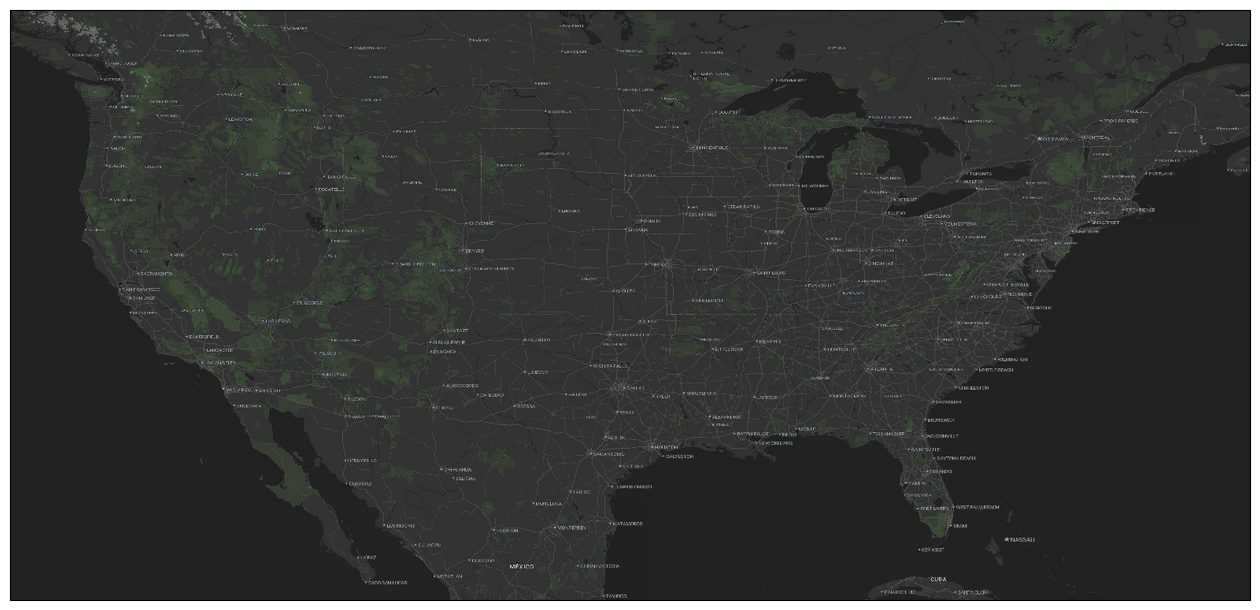

In [57]:
# FYI Pickling does not save the variable states - the code is re-run and the api is called again
pickle.load(open("dark_tile.pickle","rb"))
plt.show()

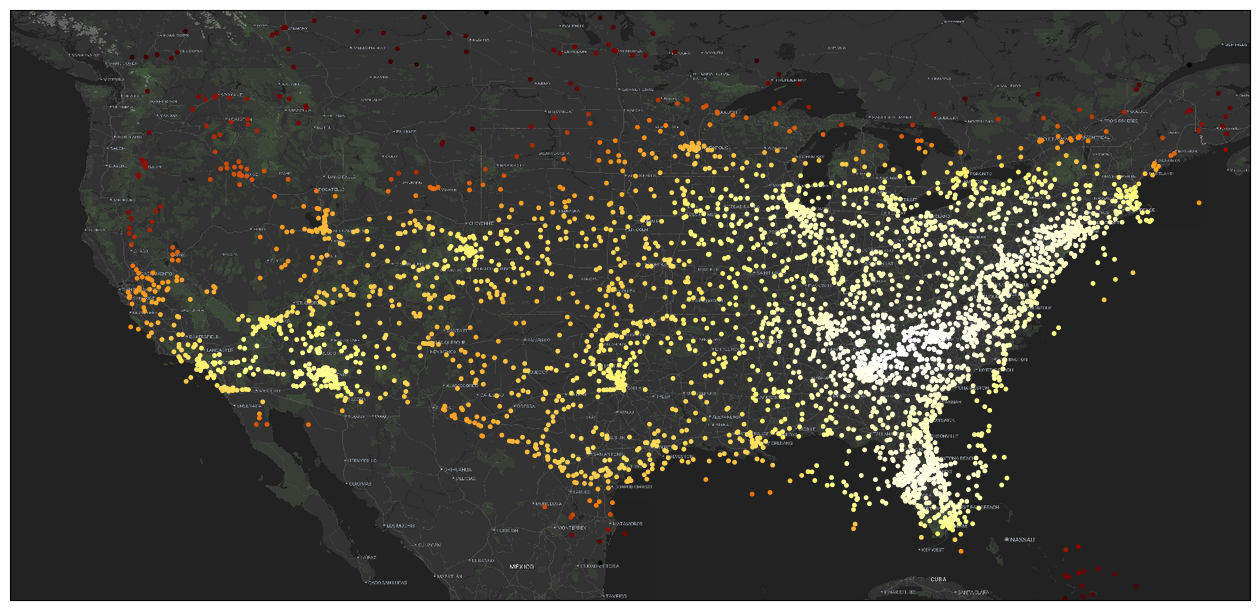

In [55]:
ax = pickle.load(open("dark_tile.pickle","rb"))
ax.scatter(filtered_airspace['x'],filtered_airspace['y'],c=density, cmap='afmhot', transform=ccrs.PlateCarree(),s=6,norm=LogNorm()) 
plt.show()

In [53]:
with open(f'/home/filpill/work/flight_tracking/scripts/keys/stadiamaps.key', 'r') as f:
    creds = f.read().strip().split(' ')
    API_KEY = creds[0]
os.environ['API_KEY'] = API_KEY
map_tile = cimgt.StadiaMapsTiles(apikey=API_KEY,style='alidade_smooth_dark',resolution="@2x") 

In [54]:
#fig = plt.figure(figsize =(16,9))
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.add_image(map_tile,6,interpolation='spline36')
#ax.scatter(filtered_airspace['x'],filtered_airspace['y'],c=density, cmap='afmhot', transform=ccrs.PlateCarree(),s=7,norm=LogNorm(),alpha=0.85) 
#ax.set_extent(region_config.get('set_extent'), crs=ccrs.PlateCarree())